In [1]:
import os
import re
import nrrd
import scipy 

import numpy as np
import pandas as pd

from sklearn.neighbors import DistanceMetric

from sklearn.cluster import KMeans
from resizeimage import resizeimage
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

from scipy import stats
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy
from sklearn.neighbors import DistanceMetric

from ioutil import relative_paths

#from skimage.measure import compare_ssim as ssim

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams, cycler
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
patient_id = np.load('./../../data_source/patient_id.npy')

In [3]:
paths_to_ct = relative_paths('./../../data_source/images/ct_nrrd', target_format='nrrd')
paths_to_pet = relative_paths('./../../data_source/images/pet_nrrd', target_format='nrrd')
paths_to_mask = relative_paths('./../../data_source/images/masks_nrrd', target_format='nrrd')

ct = {}
pet = {}
mask = {}
ct_cropped = {}
pet_cropped = {}

for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image

    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image
    
    mask_image, _ = nrrd.read(paths_to_mask[num])
    mask[paths_to_mask[num]] = mask_image
    
    ct_cropped[path_to_ct] = ct[path_to_ct] * mask_image

    pet_cropped[paths_to_pet[num]] = pet[paths_to_pet[num]] * mask_image

# CT & PET GL Statistics

In [4]:
def gl_statistics(image):
    
    _image = np.copy(image)
    _image[image == 0] = np.nan

    return {
        'gl_mean': np.nanmean(_image),
        'gl_median': np.nanmedian(_image),
        'gl_min': np.nanmin(_image),
        'gl_max': np.nanmax(_image),
    }

In [5]:
# Complete image statistics. 
ct_stats, pet_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet.values(), ct.values())):
  
    pet_stats[num] = gl_statistics(pet_image)
    ct_stats[num] = gl_statistics(ct_image)
    
# Cropped image statistics.
ct_cropped_stats, pet_cropped_stats = {}, {}
for num, (cropped_pet_image, cropped_ct_image) in enumerate(zip(pet_cropped.values(), ct_cropped.values())):
    
    pet_cropped_stats[num] = gl_statistics(cropped_pet_image)
    ct_cropped_stats[num] = gl_statistics(cropped_ct_image)
    
    
df_ct_stats = pd.DataFrame(ct_stats)
df_ct_cropped_stats = pd.DataFrame(ct_cropped_stats)

df_pet_stats = pd.DataFrame(pet_stats)
df_pet_cropped_stats = pd.DataFrame(pet_cropped_stats)

df_ct_stats.columns = patient_id
df_ct_cropped_stats.columns = patient_id

df_pet_stats.columns = patient_id
df_pet_cropped_stats.columns = patient_id

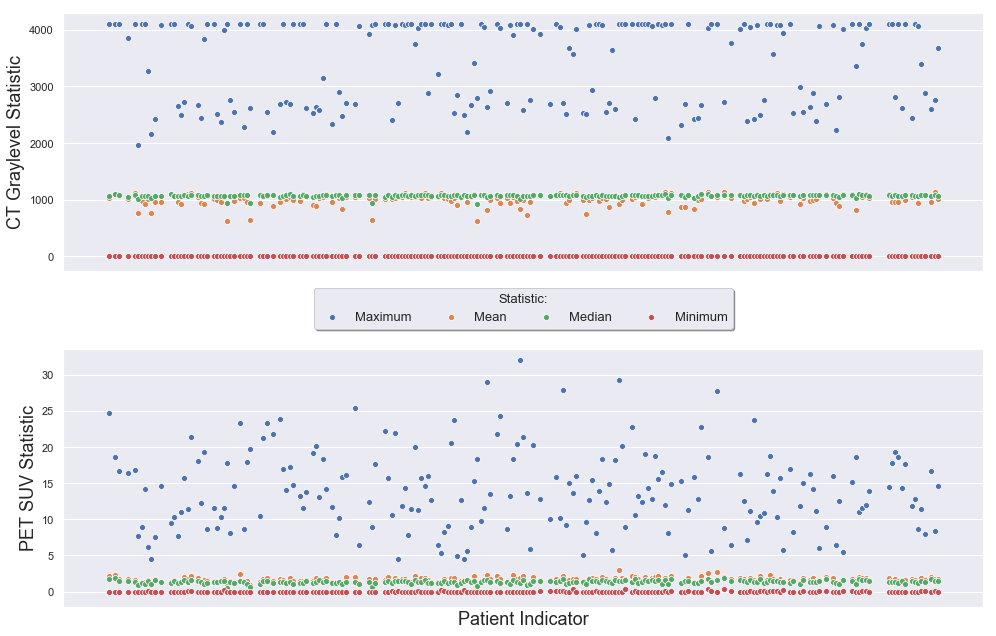

In [6]:
# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
sns.set()
#rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'y'])
fig, (ct_axis, pet_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Maximum', 'Mean', 'Median', 'Minimum']
for num, (ct_row_label, pet_row_label) in enumerate(zip(df_ct_stats.T, df_pet_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_stats.columns.values), 
        y=np.squeeze(df_pet_stats.loc[pet_row_label, :].values),
        ax=pet_axis,
        cmap='muted',
        label=labels[num]
    )
    sns.scatterplot(
        x=np.squeeze(df_ct_stats.columns.values), 
        y=np.squeeze(df_ct_stats.loc[ct_row_label, :].values),
        ax=ct_axis,
        cmap='muted',
    )
pet_axis.legend(
    title='Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
pet_axis.set_ylabel('PET SUV Statistic', fontsize=18)
ct_axis.set_ylabel('CT Graylevel Statistic', fontsize=18)

plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './pet_ct_img_value_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [7]:
np.sum(df_ct_stats.loc['gl_max'].astype(int) == 4094), np.sum(df_ct_stats.loc['gl_max'].astype(int) != 4094), 2**12

(70, 128, 4096)

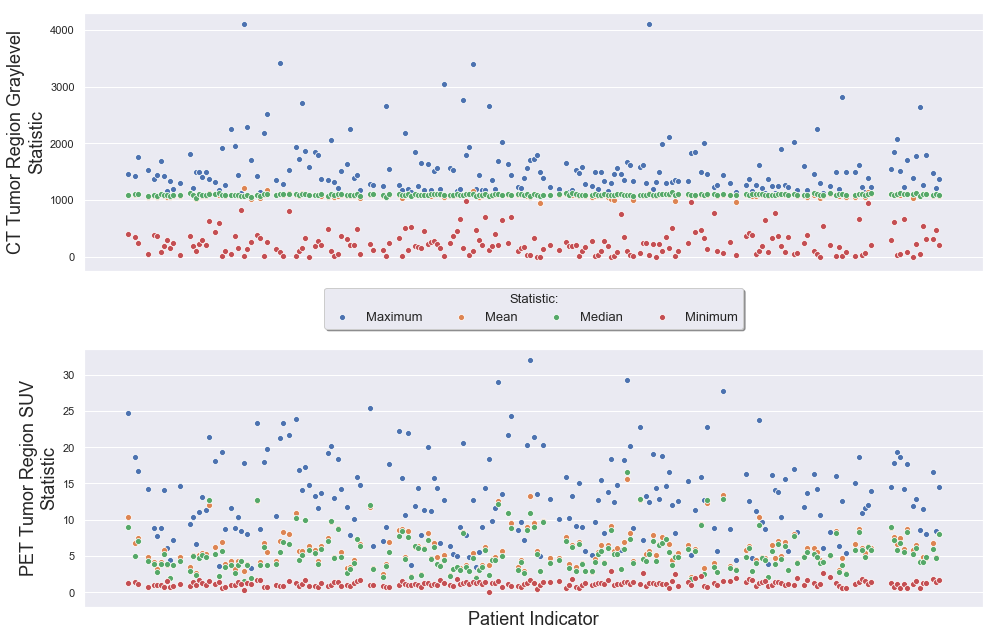

In [8]:
# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
sns.set()
#rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'y'])
fig, (ct_cropped_axis, pet_cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Maximum', 'Mean', 'Median', 'Minimum']
for num, (ct_cropped_row_label, pet_cropped_row_label) in enumerate(zip(df_ct_cropped_stats.T, df_pet_cropped_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_stats.loc[pet_cropped_row_label, :].values),
        ax=pet_cropped_axis,
        cmap='muted',
        label=labels[num]
    )
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_stats.loc[ct_cropped_row_label, :].values),
        ax=ct_cropped_axis,
        cmap='muted',
    )
pet_cropped_axis.legend(
    title='Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
pet_cropped_axis.set_ylabel('PET Tumor Region SUV\nStatistic', fontsize=18)
ct_cropped_axis.set_ylabel('CT Tumor Region Graylevel\nStatistic', fontsize=18)

plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './cropped_pet_ct_img_value_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [9]:
np.var(df_ct_cropped_stats.loc['gl_median']), np.var(df_ct_stats.loc['gl_median']), 

(177.68836423111355, 551.7217345115225)

# Clustering of CT Max GL Statistic

In [10]:
sns.set()

# Cluster Euclidean distances between CT max values.
euc_dist = DistanceMetric.get_metric('euclidean')
euc_dist_mat = euc_dist.pairwise(df_ct_stats.loc['gl_max', :].values[:, np.newaxis])

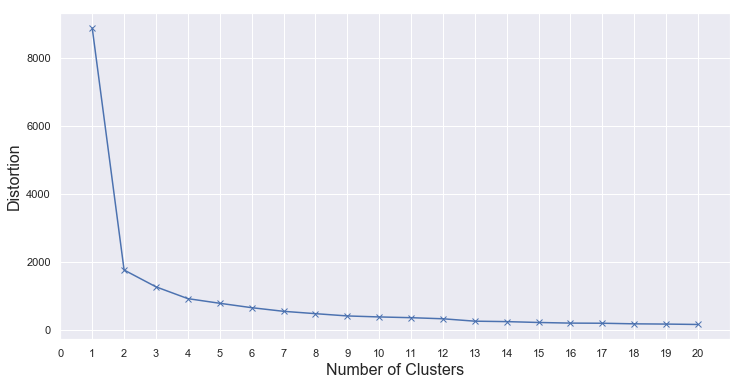

In [31]:
# The Elbow Method showing the optimal k
clusters = np.arange(1, 21)

distortions = []
for cluster in clusters:
    model = KMeans(n_clusters=cluster, random_state=0).fit(euc_dist_mat)
    distortions.append(sum(np.min(cdist(euc_dist_mat, model.cluster_centers_, 'euclidean'), axis=1)) / euc_dist_mat.shape[0])

plt.figure(figsize=(12, 6))
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Distortion', fontsize=16)
plt.xticks(np.arange(np.size(clusters) + 1), np.arange(0, 22))
plt.xlim([0, 21])
plt.savefig(
    './kmeans_elbow',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

In [12]:
model = KMeans(n_clusters=2, random_state=0).fit(euc_dist_mat)
y_pred_kmeans = model.predict(euc_dist_mat)
gl_max_thresh_kmeans = np.max(df_ct_stats.loc['gl_max', :].values[y_pred_kmeans==1])
print(gl_max_thresh_kmeans)

3279.2492561226827


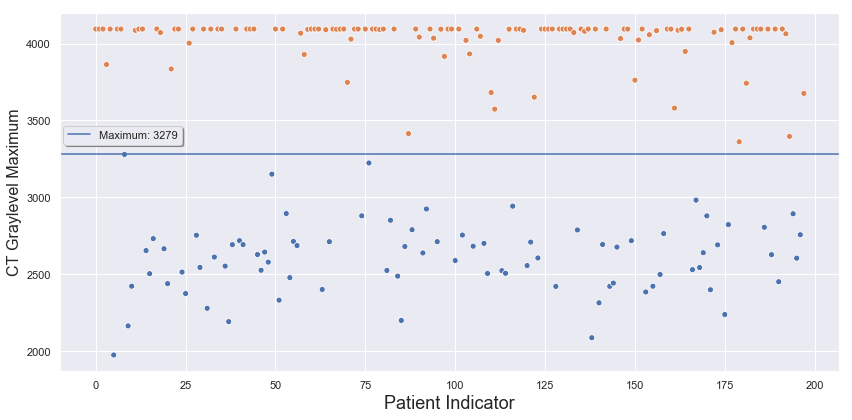

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    np.arange(198),
    np.squeeze(df_ct_stats.loc['gl_max', :].values),
    hue=y_pred_kmeans==0,
    legend=False,
)
plt.ylabel('CT Graylevel Maximum', fontsize=16)
plt.xlabel('Patient Indicator', fontsize=18)
plt.axhline(y=gl_max_thresh_kmeans)
plt.legend(
    [f'Maximum: {int(gl_max_thresh_kmeans)}'],
    loc='upper center', bbox_to_anchor=(0.08, 0.7),
    ncol=1, fancybox=True, shadow=True
)
plt.savefig(
    './kmeans_clustering_ct_max',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)
plt.tight_layout()

# Examples Damaged Slices

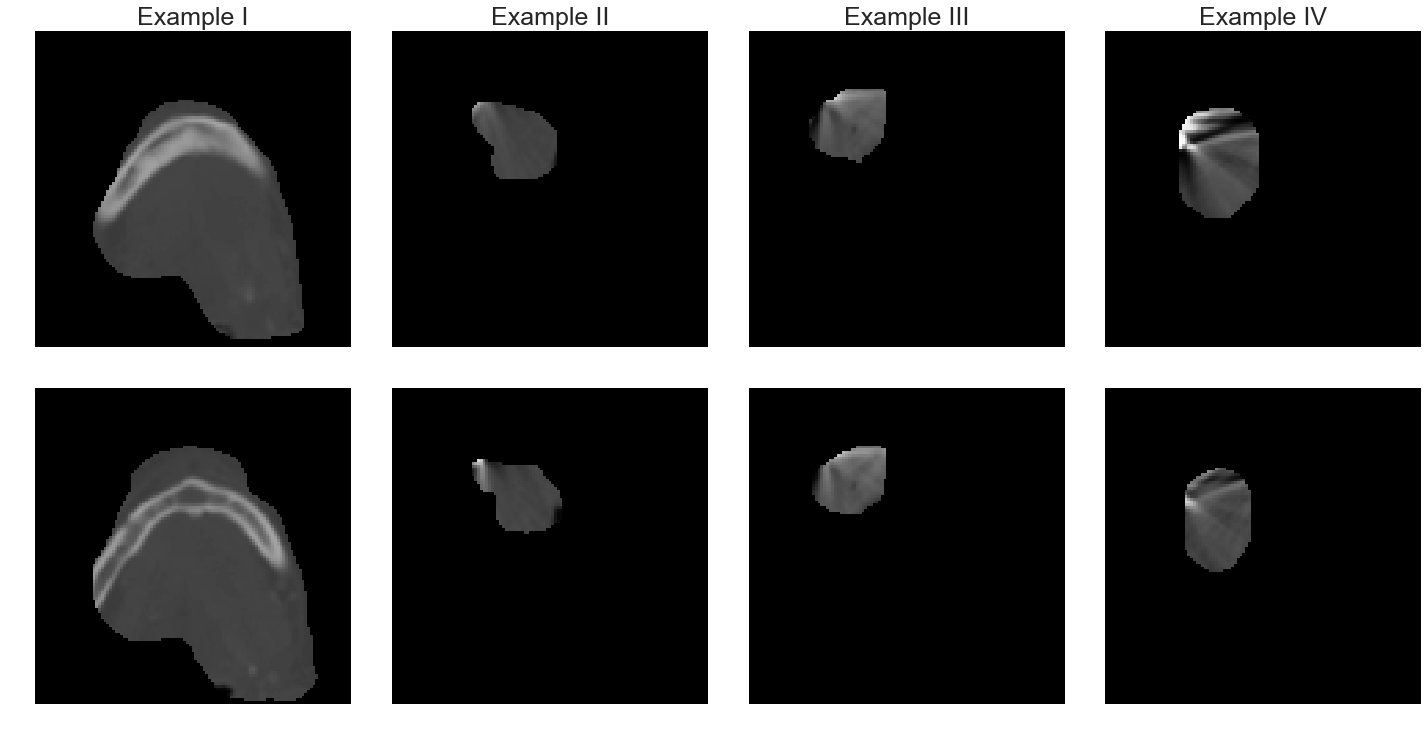

In [19]:
# Some of the artifacts found in the CT scans of the patients exceeding 3027 GL intensity.

row_a = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][:, :, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][:, :, 59],
]
row_b = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 57],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][:, :, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][:, :, 48],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][:, :, 61],
]

new_rows, new_cols = 115, 115
titles = ['Example I', 'Example II', 'Example III', 'Example IV']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 20))
for num in range(len(row_a)):
    
    rows_a, cols_a = np.shape(row_a[num])
    rows_b, cols_b = np.shape(row_b[num])
    new_image_a = np.zeros((new_rows, new_cols))
    new_image_b = np.zeros((new_rows, new_cols))
    new_image_a[:rows_a, :cols_a] = row_a[num][:new_rows, :new_cols]
    new_image_b[:rows_b, :cols_b] = row_b[num][:new_rows, :new_cols]

    axes[0, num].imshow(
        new_image_a[:, :],
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    axes[0, num].set_title(titles[num], fontsize=25)
    axes[1, num].imshow(
        new_image_b[:, :],
        cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12
    )
    axes[0, num].axis('off')   
    axes[1, num].axis('off')   
    
plt.subplots_adjust(hspace=-0.95, wspace=-0.1)
plt.tight_layout()
plt.savefig(
    './damaged_slices.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Statistics Removed Damaged Slices Images

In [16]:
paths_to_ct = relative_paths('./../../data_source/images/ct_removed_broken_slices', target_format='nrrd')
paths_to_ct_mask = relative_paths('./../../data_source/images/masks_removed_broken_slices_ct_size', target_format='nrrd')

paths_to_pet = relative_paths('./../../data_source/images/pet_removed_broken_slices', target_format='nrrd')
paths_to_pet_mask = relative_paths('./../../data_source/images/masks_removed_broken_slices_pet_size', target_format='nrrd')

ct_rs_cropped = {}
pet_rs_cropped = {}
for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    mask_ct_image, _ = nrrd.read(paths_to_ct_mask[num])

    pet_image, _ = nrrd.read(paths_to_pet[num])
    mask_pet_image, _ = nrrd.read(paths_to_pet_mask[num])
    
    ct_rs_cropped[path_to_ct] = ct_image * mask_ct_image
    pet_rs_cropped[paths_to_pet[num]] = pet_image * mask_pet_image

In [17]:
# Cropped image statistics.
ct_rs_cropped_stats, pet_rs_cropped_stats = {}, {}
for num, (cropped_pet_image, cropped_ct_image) in enumerate(zip(pet_rs_cropped.values(), ct_rs_cropped.values())):
    
    pet_rs_cropped_stats[num] = gl_statistics(cropped_pet_image)
    ct_rs_cropped_stats[num] = gl_statistics(cropped_ct_image)
    
df_ct_rs_cropped_stats = pd.DataFrame(ct_rs_cropped_stats)
df_pet_rs_cropped_stats = pd.DataFrame(pet_rs_cropped_stats)

df_ct_rs_cropped_stats.shape, df_pet_rs_cropped_stats.shape

((4, 187), (4, 187))

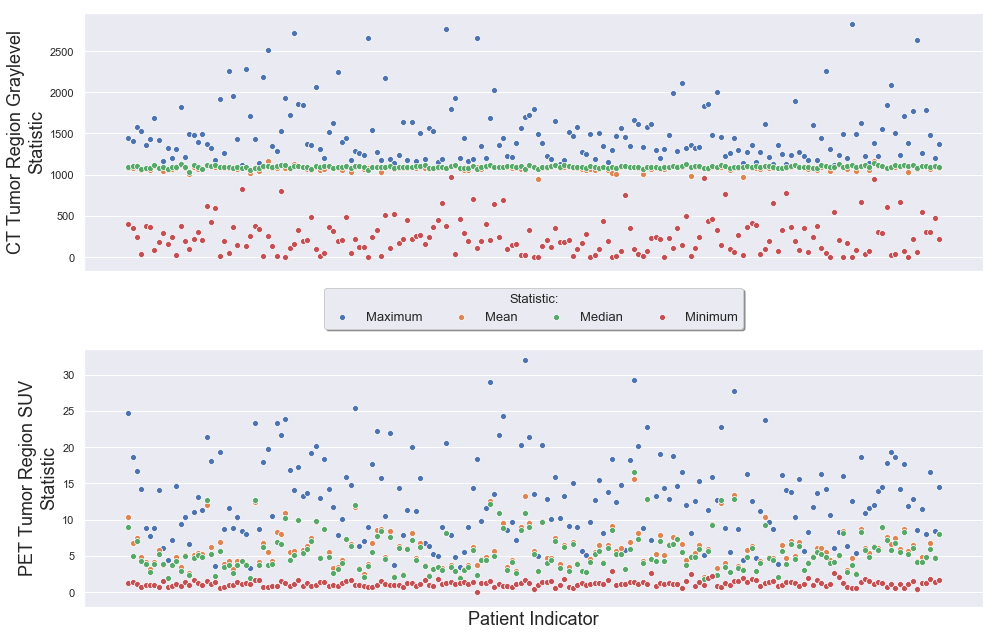

In [18]:
sns.set()
fig, (ct_cropped_axis, pet_cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Maximum', 'Mean', 'Median', 'Minimum']
for num, (ct_cropped_row_label, pet_cropped_row_label) in enumerate(
    zip(df_ct_rs_cropped_stats.T, df_pet_rs_cropped_stats.T)
):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_rs_cropped_stats.columns.values), 
        y=np.squeeze(df_pet_rs_cropped_stats.loc[pet_cropped_row_label, :].values),
        ax=pet_cropped_axis,
        cmap='muted',
        label=labels[num]
    )
    sns.scatterplot(
        x=np.squeeze(df_ct_rs_cropped_stats.columns.values), 
        y=np.squeeze(df_ct_rs_cropped_stats.loc[ct_cropped_row_label, :].values),
        ax=ct_cropped_axis,
        cmap='muted',
    )
pet_cropped_axis.legend(
    title='Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
pet_cropped_axis.set_ylabel('PET Tumor Region SUV\nStatistic', fontsize=18)
ct_cropped_axis.set_ylabel('CT Tumor Region Graylevel\nStatistic', fontsize=18)

plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './rs_cropped_pet_ct_img_value_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)